In [2]:
# handle data
import pyspark.sql as ps
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense 

# train data|
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

2023-01-03 07:57:05.846897: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
symbol = "BTCUSDT"
PERIOD = "1d"

In [4]:
pd_df = pd.read_csv(f"../../datastore/price/{symbol}_{PERIOD}.csv")
pd_df

,Kline open time,Open price,High price,Low price,Close price,Volume,Kline Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
0,1517184000000,11879.95,11975.02,11139.55,11251.00,14170.377538,1517270399999,1.621102e+08,169199,6016.496871,6.881997e+07
1,1517270400000,11250.11,11308.42,9900.00,10237.51,25554.372946,1517356799999,2.689783e+08,259212,11388.096419,1.198643e+08
2,1517356800000,10230.00,10425.85,9700.00,10285.10,18015.956805,1517443199999,1.816442e+08,201422,8782.584442,8.860927e+07
3,1517443200000,10285.10,10335.00,8750.99,9224.52,33564.764311,1517529599999,3.176363e+08,316020,15430.003849,1.461307e+08
4,1517529600000,9224.52,9250.00,8010.02,8873.03,49971.626975,1517615999999,4.342365e+08,453411,23113.503584,2.012927e+08
...,...,...,...,...,...,...,...,...,...,...,...
1795,1672272000000,16547.32,16664.41,16488.91,16633.47,160998.471580,1672358399999,2.671666e+09,4553877,80977.624430,1.343800e+09
1796,1672358400000,16633.47,16677.35,16333.00,16607.48,164916.311740,1672444799999,2.726831e+09,4310415,82170.474900,1.358631e+09
1797,1672444800000,16607.48,16644.09,16470.00,16542.40,114490.428640,1672531199999,1.897048e+09,3344374,57021.069190,9.448344e+08
1798,1672531200000,16541.77,16628.00,16499.01,16616.75,96925.413740,1672617599999,1.604794e+09,3218355,48548.781680,8.038417e+08


In [5]:
pd_df = pd_df.set_index("Kline open time").sort_index()
pd_df.index = pd.to_datetime(pd_df.index, unit='ms')
pd_df

,Open price,High price,Low price,Close price,Volume,Kline Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
Kline open time,,,,,,,,,,
2018-01-29,11879.95,11975.02,11139.55,11251.00,14170.377538,1517270399999,1.621102e+08,169199,6016.496871,6.881997e+07
2018-01-30,11250.11,11308.42,9900.00,10237.51,25554.372946,1517356799999,2.689783e+08,259212,11388.096419,1.198643e+08
2018-01-31,10230.00,10425.85,9700.00,10285.10,18015.956805,1517443199999,1.816442e+08,201422,8782.584442,8.860927e+07
2018-02-01,10285.10,10335.00,8750.99,9224.52,33564.764311,1517529599999,3.176363e+08,316020,15430.003849,1.461307e+08
2018-02-02,9224.52,9250.00,8010.02,8873.03,49971.626975,1517615999999,4.342365e+08,453411,23113.503584,2.012927e+08
...,...,...,...,...,...,...,...,...,...,...
2022-12-29,16547.32,16664.41,16488.91,16633.47,160998.471580,1672358399999,2.671666e+09,4553877,80977.624430,1.343800e+09
2022-12-30,16633.47,16677.35,16333.00,16607.48,164916.311740,1672444799999,2.726831e+09,4310415,82170.474900,1.358631e+09
2022-12-31,16607.48,16644.09,16470.00,16542.40,114490.428640,1672531199999,1.897048e+09,3344374,57021.069190,9.448344e+08


In [6]:
pd_df["Open price"] = pd_df["Open price"].apply(lambda price: float(price))

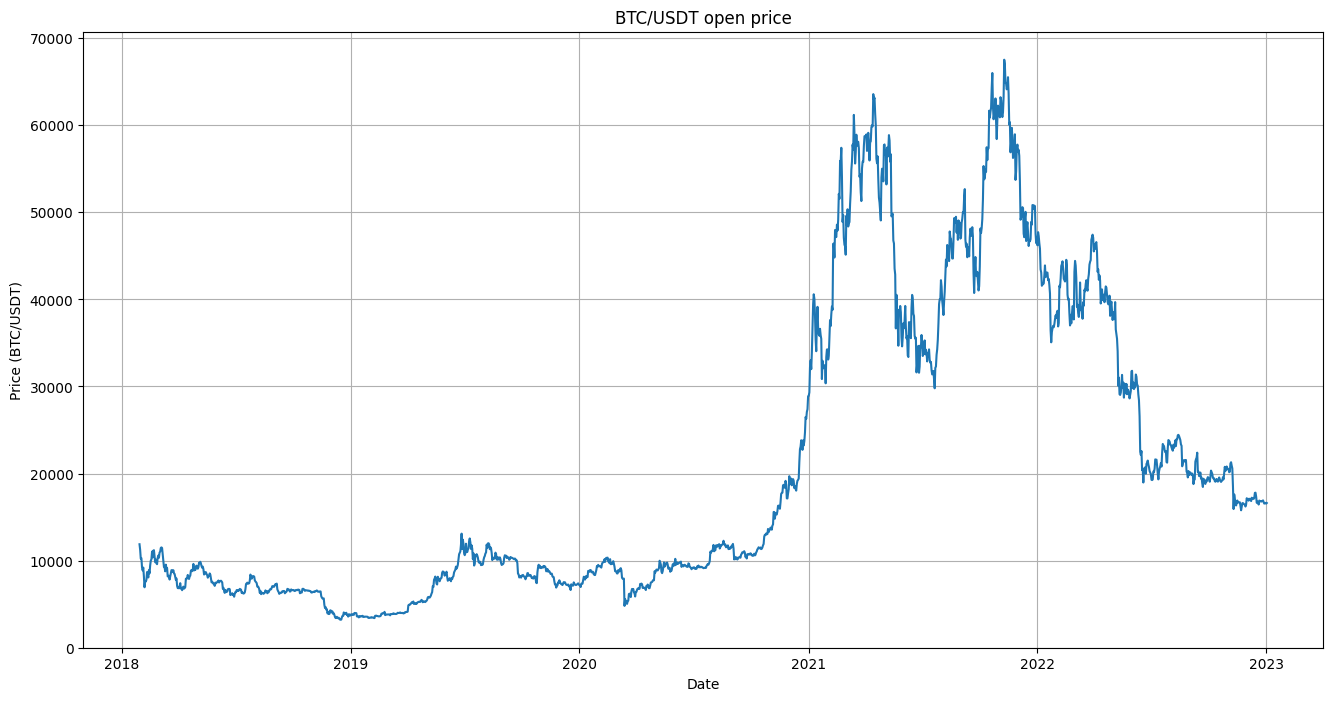

In [7]:
plt.figure(figsize=(16,8),)
plt.title("BTC/USDT open price")
plt.plot(pd_df["Open price"])
plt.ylabel("Price (BTC/USDT)")
plt.xlabel("Date")
plt.grid()
plt.show()

In [8]:
dataset = pd_df.filter(["Open price"]).values

In [9]:
TRAIN_DATA_LENGTH = int(len(dataset) * 0.8)
dataset

array([[11879.95],
       [11250.11],
       [10230.  ],
       ...,
       [16607.48],
       [16541.77],
       [16617.17]])

In [10]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

In [11]:
scaled_data

array([[0.13477976],
       [0.12498657],
       [0.1091252 ],
       ...,
       [0.20828664],
       [0.20726494],
       [0.20843731]])

In [12]:
train_data = scaled_data[:TRAIN_DATA_LENGTH]

X_train = []
Y_train = []
for i in range(60,len(train_data)):
    X_train.append(train_data[i-60:i,:])
    Y_train.append(train_data[i,:])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [13]:
model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(200, return_sequences=False))
model.add(Dense(100))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

2023-01-03 07:57:12.659592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
model.fit(X_train, Y_train, batch_size=1, epochs=2)

Epoch 1/2
1380/1380 [==============================] - 28s 19ms/step - loss: 0.0048
Epoch 2/2
1380/1380 [==============================] - 26s 19ms/step - loss: 0.0011


In [15]:
test_data = scaled_data[TRAIN_DATA_LENGTH-60:]

X_test = []
Y_test = []
for i in range(60,len(test_data)):
    X_test.append(test_data[i-60:i,:])
    Y_test.append(test_data[i,:])

X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [16]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

12/12 [==============================] - 1s 32ms/step


In [17]:
data = pd_df.filter(["Open price"])
train = data[:TRAIN_DATA_LENGTH]
valid = data[TRAIN_DATA_LENGTH:].reset_index()
valid["predict_price"] = predictions
valid = valid.set_index("Kline open time")
valid["predict_price"]= valid["predict_price"].apply(lambda price: float(price))

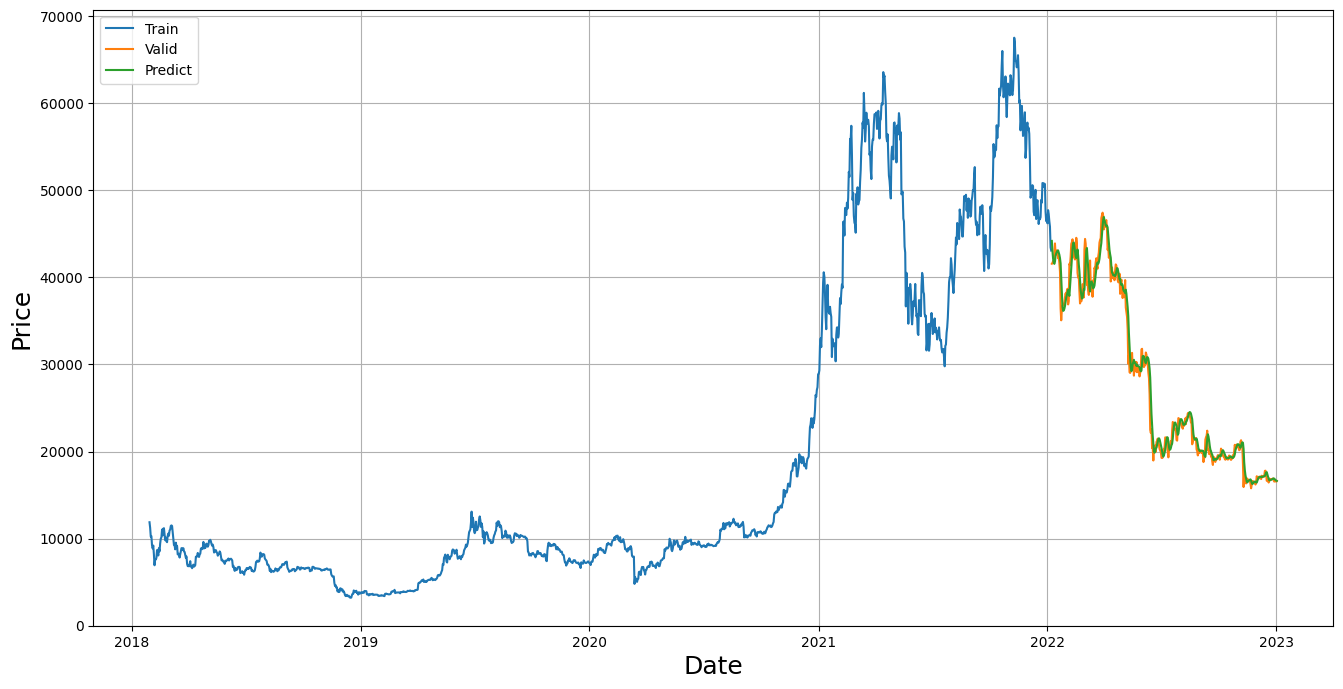

In [18]:
plt.figure(figsize=(16,8))
plt.xlabel("Date", fontsize= 18)
plt.ylabel("Price", fontsize= 18)
plt.plot(train["Open price"])
plt.plot(valid[["Open price","predict_price"]])
plt.legend(["Train","Valid", "Predict"],loc="upper left")
plt.grid()
plt.show()


In [19]:
X_test = scaled_data[-60:]
X_test = np.array(X_test)
X_test = X_test.reshape(1, 60, 1)
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

1/1 [==============================] - 0s 20ms/step


### Recent price

In [20]:
data[-10:]

,Open price
Kline open time,
2022-12-24,16778.52
2022-12-25,16835.73
2022-12-26,16832.11
2022-12-27,16919.39
2022-12-28,16706.06
2022-12-29,16547.32
2022-12-30,16633.47
2022-12-31,16607.48
2023-01-01,16541.77


### Tomorrow price

In [21]:
predictions[0,0]

16617.781

In [49]:
from statsmodels.tsa.arima.model import ARIMA

In [60]:
X = pd_df["Open price"].values

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data).reshape(-1)
train, test = scaled_data[:TRAIN_DATA_LENGTH], scaled_data[TRAIN_DATA_LENGTH:]
history = train.copy().tolist()

predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    pred_price = output[0]
    predictions.append(pred_price)
    actual_price = test[t]
    history.append(actual_price)

/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/minico

/var/folders/p7/08wxvf195r35gt2pw893ynsw0000gn/T/ipykernel_2313/244219546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["Predict"] = scaler.inverse_transform(np.array(predictions).reshape(-1,1)).reshape(-1)


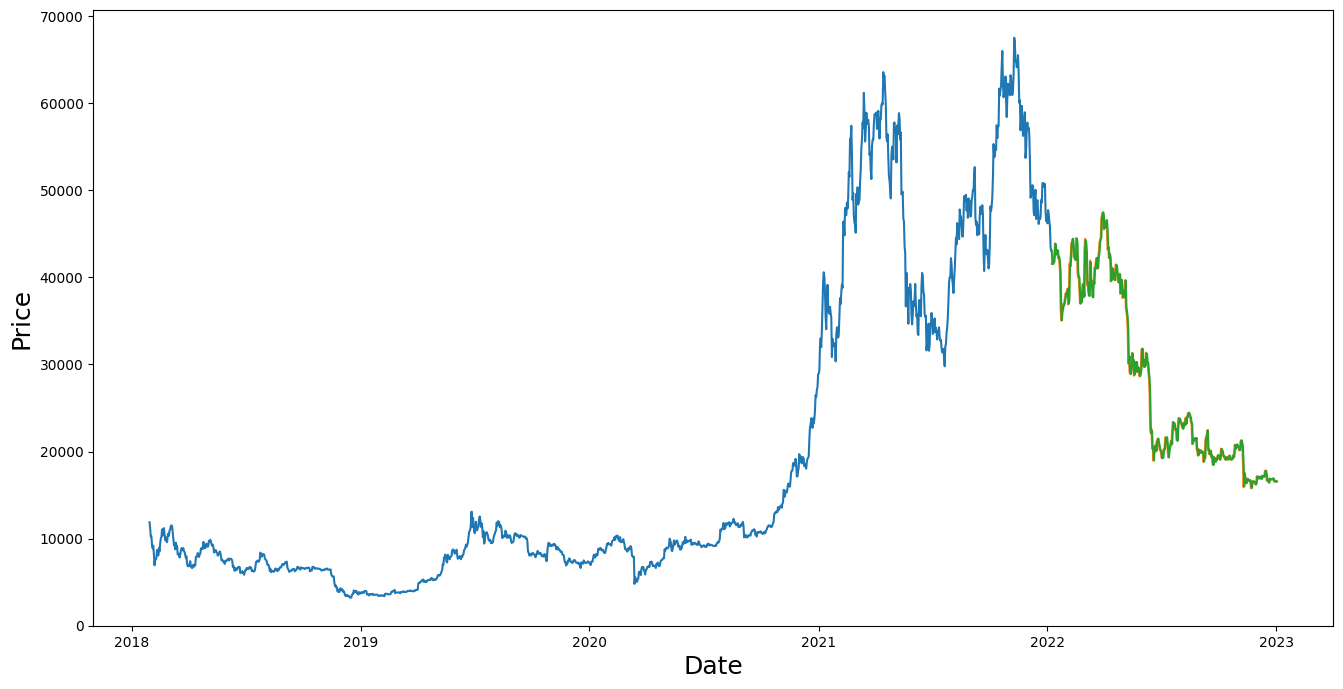

In [63]:
train_df, test_df = data[:TRAIN_DATA_LENGTH], data[TRAIN_DATA_LENGTH:]
test_df["Predict"] = scaler.inverse_transform(np.array(predictions).reshape(-1,1)).reshape(-1)

plt.figure(figsize=(16,8))
plt.xlabel("Date", fontsize= 18)
plt.ylabel("Price", fontsize= 18)
plt.plot(train_df["Open price"])
plt.plot(test_df[["Open price","Predict"]])
plt.show()

In [25]:
model = ARIMA(data["Open price"].values, order=(5,1,0))
model_fit = model.fit()
output = model_fit.forecast()
pred_price = output[0]

### Tomorrow price

In [26]:
pred_price

16614.824564342216

In [70]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, f1_score, fbeta_score, mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin

tscv = TimeSeriesSplit()
metric = make_scorer(mean_squared_error)

class ArimaEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, order=(5,1,0)):
        self.order = order
    def fit(self, X, y):
        return self
    def predict(self, X):
        pred = []
        for i in range(X.shape[0]):
            self.model = ARIMA(X[i], order=self.order)
            self.model_fit = self.model.fit()
            pred.append(self.model_fit.forecast()[0])
        return pred
    
class LSTMEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, epochs=2, batch_size=1, neurons=200):
        self.epochs = epochs
        self.batch_size = batch_size
        self.neurons = neurons
    def fit(self, X, y):
        self.model = Sequential()
        self.model.add(LSTM(self.neurons, return_sequences=True, input_shape=(X.shape[1], 1)))
        self.model.add(LSTM(self.neurons, return_sequences=False))
        self.model.add(Dense(100))
        self.model.add(Dense(1))
        self.model.compile(optimizer='adam', loss='mean_squared_error')
        self.model.fit(X, y, batch_size=self.batch_size, epochs=self.epochs)
        return self
    def predict(self, X):
        return self.model.predict(X)
    
arima_model = ArimaEstimator()
lstm_model = LSTMEstimator()

scores_1 = cross_val_score(arima_model, X_train.reshape(X_train.shape[0],X_train.shape[1]), Y_train, scoring=metric, cv=tscv, n_jobs=-1)
scores_2 = cross_val_score(lstm_model, X_train, Y_train, scoring=metric, cv=tscv, n_jobs=-1)

/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/miniconda3/envs/NaDS/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/na/opt/minico

Epoch 1/2
Epoch 1/2
Epoch 1/2
Epoch 1/2
Epoch 1/2
230/230 [==============================] - 38s 154ms/step - loss: 1.8610e-04
Epoch 2/2
920/920 [==============================] - 134s 143ms/step - loss: 2.0444e-04
Epoch 2/2
1150/1150 [==============================] - 156s 134ms/step - loss: 0.0036
Epoch 2/2
8/8 [==============================] - 1s 26ms/step


In [71]:
pd.DataFrame({'arima':scores_1, 'lstm':scores_2})

,arima,lstm
0,0.000024,0.000509
1,0.000029,0.000801
2,0.000036,0.000069
3,0.000817,0.001132
4,0.000788,0.000985
